In [1]:
import os.path as op

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ocsmesh
import pyproj
from bluemath_tk.topo_bathy.mesh_utils import (
    adcirc2netcdf,
    buffer_aera,
    clip_bathymetry,
    define_mesh_target_size,
    detect_circumcenter_too_close,
    mask_points_outside_polygon,
    plot_bathymetry,
    plot_bathymetry_interp,
    plot_boundaries,
    plot_mesh_edge,
    plot_mesh_vals,
    simply_polygon,
    remove_islands,
)
from bluemath_tk.topo_bathy.OCSMod import EuclideanMesh2D
from pyproj import CRS
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import transform

### Grid Parameters

In [2]:
Mean_Sea_Level = 2.5

In [3]:
bathymetry_tif_raw_path = "/home/grupos/geocean/faugeree/BlueMath/toolkit/input/bati_santander_5m.tif"

initial_raster_paths = [bathymetry_tif_raw_path]
output_bathy_clip_tif_path = "/home/grupos/geocean/faugeree/BlueMath/toolkit/output/bati_santander_5m_clip.tif"

site = "Cantabria"

In [4]:
coords = [
    [-3.7866479146,43.4899215808],
    [-3.7848430550,43.4925807407],
    [-3.7830141305,43.4975621534],
    [-3.7787615240,43.5243841540],
    [-3.6967833882,43.5113996928],
    [-3.7018375592,43.4793138002],
    [-3.7288593164,43.4277700164],
    [-3.7773739441,43.3973521150],
    [-3.8416750775,43.3819506459],
    [-3.8470655917,43.4058229230],
    [-3.8278137554,43.4547225874],
    [-3.7912352663,43.4866806357],
    [-3.7912352663,43.4866806357],
    [-3.7866479146,43.4899215808],]

In [5]:
lon_center = np.mean(np.array(coords)[-1, 0])
lat_center = np.mean(np.array(coords)[-1, 1])

proj_str = (
    f"+proj=aeqd +lat_0={lat_center} +lon_0={lon_center} +units=m +datum=WGS84 + no_defs"
)
project = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True).transform

### Raster

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

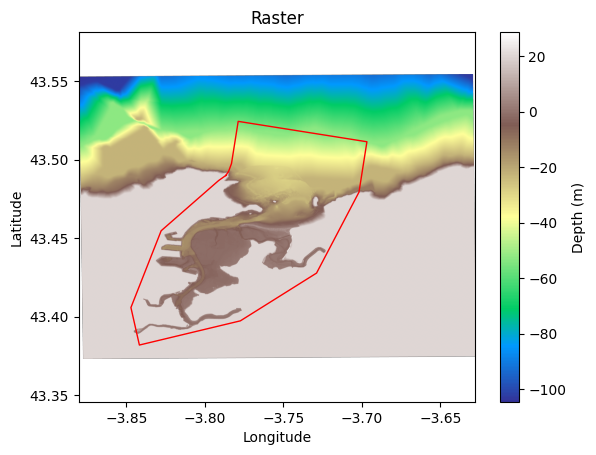

In [6]:
domain_crs = CRS.from_user_input("epsg:4326")
domain_polygon = Polygon(coords)


fig, ax = plt.subplots()
plot_bathymetry(initial_raster_paths, domain_polygon, ax)

<Axes: title={'center': 'Raster'}, xlabel='Longitude', ylabel='Latitude'>

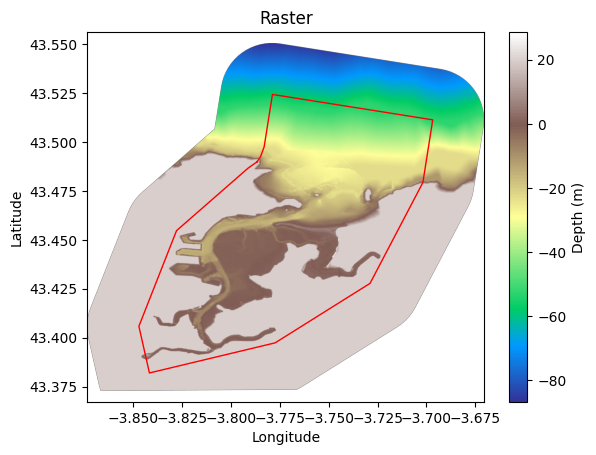

In [7]:
raster_resolution = clip_bathymetry(
    input_raster_paths=initial_raster_paths,
    output_path=output_bathy_clip_tif_path,
    domain=domain_polygon,
    margin=1,
)
clipped_raster_paths = [output_bathy_clip_tif_path]

x_center, y_center = project(lon_center, lat_center)
x_center_raster_resolution, y_center_raster_resolution = project(
    lon_center + raster_resolution / np.sqrt(2),
    lat_center + raster_resolution / np.sqrt(2),
)
raster_resolution_meters = np.mean(
    [
        abs(x_center - x_center_raster_resolution),
        abs(y_center - y_center_raster_resolution),
    ]
)

fig, ax = plt.subplots()
plot_bathymetry(clipped_raster_paths, domain_polygon, ax)

### Generacion polygon

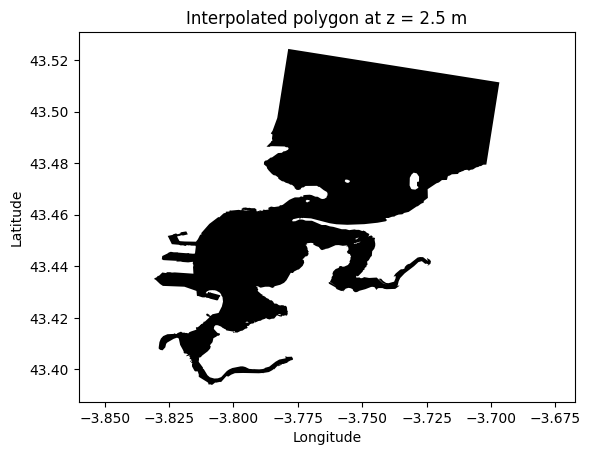

In [8]:
rasters = [ocsmesh.Raster(path) for path in clipped_raster_paths]
coastal_area = ocsmesh.Geom(rasters, zmax=Mean_Sea_Level).get_multipolygon()
intersected = coastal_area.intersection(domain_polygon)
if isinstance(intersected, MultiPolygon):
    raw_intersected_area = max(intersected.geoms, key=lambda p: p.area)
else:
    raw_intersected_area = intersected

simplyfied_polygon = simply_polygon(raw_intersected_area, 10, project)  # 10 meters simplification
intersected_area = remove_islands(simplyfied_polygon,1500, project) # island size 1500 m2 minimum

gpd.GeoSeries(intersected_area).plot(color="black")
plt.axis("equal")
plt.title(f"Interpolated polygon at z = {Mean_Sea_Level} m")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Simplificación del polígono

(np.float64(429241.3317418609),
 np.float64(445843.3026827294),
 np.float64(4802434.884096096),
 np.float64(4822332.004757224))

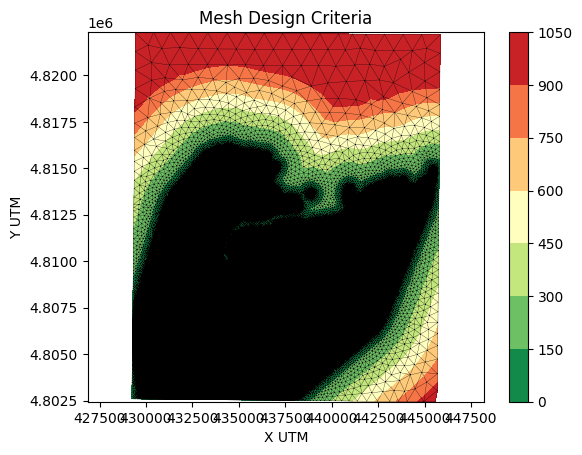

In [9]:
geometry = ocsmesh.Geom(
    [],
    base_shape=intersected_area,
    base_shape_crs=domain_crs,
)
domain_multipolygon = geometry.get_multipolygon()

# Define depth zones with mesh size and transition rate per range
# Format: (lower_bound, upper_bound): {'value': mesh_size, 'rate': expansion_rate}
expention_rate = 0.01
depth_ranges = {
    (-200_000, -80): {"value": 1000, "rate": expention_rate}, # Maximum size
    (-6, 25): {"value": 20, "rate": expention_rate}, # Minimum size
}

mesh_spacing = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges, nprocs=25
)

mesh_spacing_field = mesh_spacing.msh_t()
ax = plot_mesh_vals(mesh_spacing_field, cmap="RdYlGn_r")
plot_mesh_edge(mesh_spacing_field, lw=0.2, color="black", ax=ax)
ax.axis("equal")

In [10]:
driver = ocsmesh.JigsawDriver(geom=geometry, hfun=mesh_spacing, initial_mesh=False)
mesh = driver.run(remesh_tiny_elements=True)
mesh.interpolate(rasters, method="linear")

In [11]:
copy_mesh = EuclideanMesh2D(mesh.msh_t)
data_mesh = copy_mesh.vert2
node_coords = np.array([item["coord"] for item in data_mesh])
elements = np.array(list(ocsmesh.utils.elements(mesh.msh_t).values()))

In [12]:
to_utm = pyproj.Transformer.from_crs(
    "EPSG:4326", mesh_spacing_field.crs, always_xy=True
).transform
intersected_area_UTM = Polygon(transform(to_utm, intersected_area).exterior.coords)
intersected_area_UTM_extended = buffer_aera(intersected_area_UTM, 0.0001)

mask_generation_outside = mask_points_outside_polygon(
    elements, node_coords, intersected_area_UTM_extended
)
print(f"Number of elements outside the polygon: {mask_generation_outside.sum()}")

mask_circumcenter = detect_circumcenter_too_close(
    node_coords[:, 0], node_coords[:, 1], elements
)
print(f"Number of elements with circumcenter too close: {mask_circumcenter.sum()}")

complete_mask = mask_generation_outside | mask_circumcenter

Number of elements outside the polygon: 4878
Number of elements with circumcenter too close: 28


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


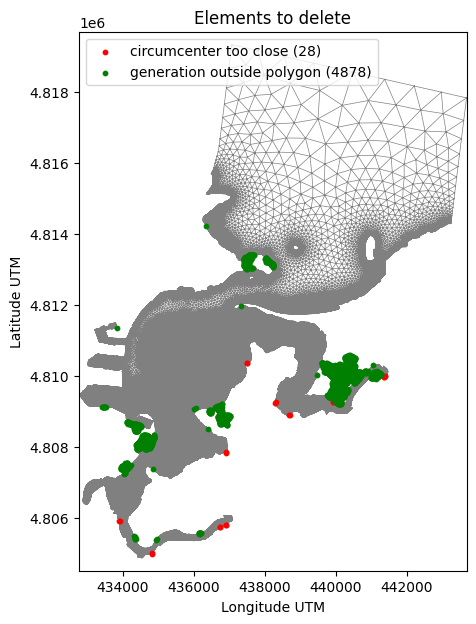

In [13]:
bad_elements_generation = np.mean(node_coords[elements[mask_generation_outside]], axis=1)
bad_elements_circumcenter = np.mean(node_coords[elements[mask_circumcenter]], axis=1)
fig, ax = plt.subplots(figsize=(5, 7))
ax.triplot(node_coords[:, 0], node_coords[:, 1], elements, color="gray", lw=0.5)
ax.scatter(
    bad_elements_circumcenter[:, 0].flatten(),
    bad_elements_circumcenter[:, 1].flatten(),
    color="red",
    s=10,
    label=f"circumcenter too close ({mask_circumcenter.sum()})",
)
ax.scatter(
    bad_elements_generation[:, 0].flatten(),
    bad_elements_generation[:, 1].flatten(),
    color="green",
    s=10,
    label=f"generation outside polygon ({mask_generation_outside.sum()})",
)
ax.axis("equal")
ax.set_title("Elements to delete")
ax.set_xlim(min(node_coords[:, 0]), max(node_coords[:, 0]))
ax.set_ylim(min(node_coords[:, 1]), max(node_coords[:, 1]))
ax.set_xlabel("Longitude UTM")
ax.set_ylabel("Latitude UTM")
ax.legend()

In [14]:
cleaned_mesh = ocsmesh.utils.clip_elements_by_index(
    copy_mesh, tria=complete_mask, quad=None
)
ocsmesh.utils.finalize_mesh(cleaned_mesh)

(np.float64(432763.97650855925),
 np.float64(443679.54004532157),
 np.float64(4804886.074953853),
 np.float64(4819343.988870546))

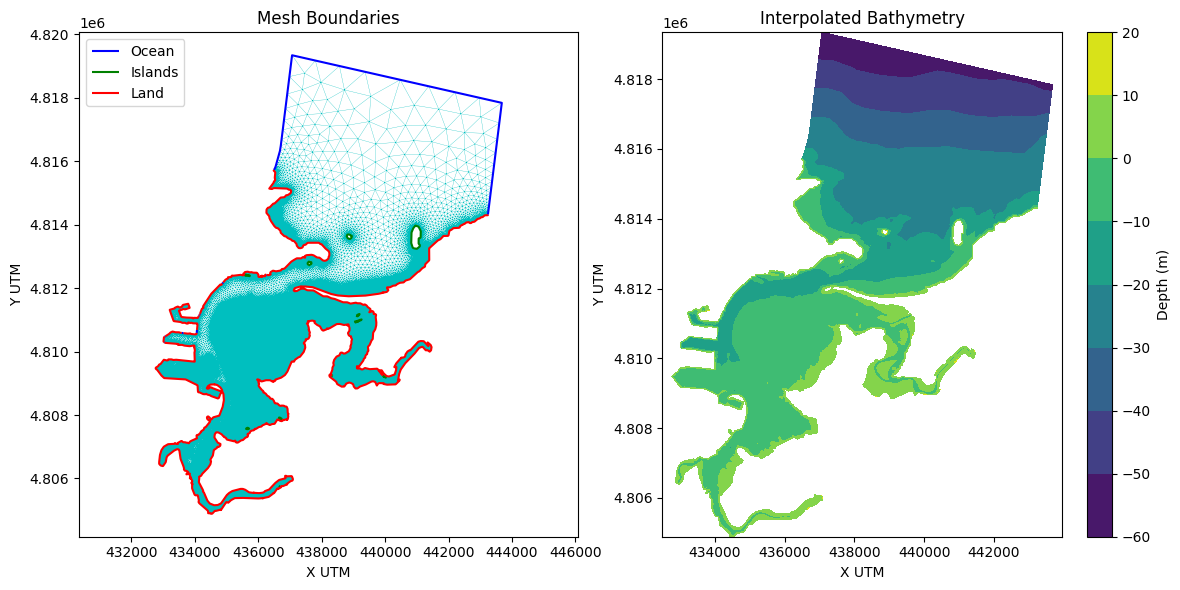

In [15]:
cleaned_mesh.interpolate(rasters, method="linear")
cleaned_mesh.boundaries.auto_generate(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_boundaries(cleaned_mesh, ax1)
plot_bathymetry_interp(cleaned_mesh, ax2)
plt.tight_layout()
plt.axis("equal")

## Save output files

In [16]:
from bluemath_tk.topo_bathy.mesh_utils import adcirc2netcdf

path_grd = op.join(f"/home/grupos/geocean/faugeree/BlueMath/toolkit/output/{site}_mesh_adcirc.grd")
path_nc = op.join(f"/home/grupos/geocean/faugeree/BlueMath/toolkit/output/{site}_mesh_net.nc")

cleaned_mesh.write(path_grd, format="grd", overwrite=True)
adcirc2netcdf(path_grd, path_nc)